### Import Dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


In [2]:
def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    order = np.argsort(tau)
    
    return pd.DataFrame([tau[order],q[order]],index=['d','q'],columns=[1,2,3])

## Get datasets

In [3]:
## RCP45:

## RCMIP SSP emissions:
ssp245_concs = RCMIP_to_GIR_input_concs('ssp245').loc[1850:].drop('halon1202',axis=1)
ssp245_concs.loc[:,['bc', 'co', 'nh3', 'nmvoc', 'nox', 'nox_avi', 'oc', 'so2']] = RCMIP_to_GIR_input_emms('ssp245').loc[1850:,['bc', 'co', 'nh3', 'nmvoc', 'nox', 'nox_avi', 'oc', 'so2']].interpolate()
ssp245_conc_co2impulse = ssp245_concs.copy()
ssp245_conc_co2impulse.loc[2015,'carbon_dioxide'] += 200
ssp245_concs = pd.concat([ssp245_concs,ssp245_conc_co2impulse],axis=1,keys=['ssp245','ssp245_co2_impulse'])

ssp245_forc = pd.concat([get_RCMIP_forc('ssp245')]*2,keys=['ssp245','ssp245_co2_impulse'],axis=1).interpolate()
ssp245_forc = ssp245_forc.loc[1850:] - ssp245_forc.loc[1870:1880].mean()

In [4]:
## get cmip6 response parameters:

def forc_vals_to_f(F_2x,F_4x,PI_conc=284):
    
    f3 = (2*F_2x - F_4x) / (2 * np.sqrt(PI_conc*2) - np.sqrt(PI_conc*4) - np.sqrt(PI_conc) )
    f1 = (F_2x - f3 * (np.sqrt(PI_conc*2) - np.sqrt(PI_conc))) / np.log(2)
    return np.array([f1,f3])

response_params = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

fair_param_df = pd.concat([convert_geoffrey_to_FaIR(x.iloc[:10]) for y,x in response_params.iteritems()],axis=1,keys=response_params.columns)

default_gas_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
default_gas_params = default_gas_params.drop([x for x in default_gas_params.columns if 'halon1202' in x],axis=1)

cmip6_gas_params = pd.concat([default_gas_params]*fair_param_df.columns.levels[0].size,axis=1,keys=fair_param_df.columns.levels[0])

cc_params = pd.read_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_240820_byOLSE_plus_rA.csv',index_col=0)

for model in cmip6_gas_params.columns.levels[0]:
    
    if model in cc_params.index:
        cmip6_gas_params.loc[['r0','rC','rT','rA'],(model,'carbon_dioxide')] = cc_params.loc[model,['r0','rC','rT','rA']]
    else:
        cmip6_gas_params.loc[['r0','rC','rT','rA'],(model,'carbon_dioxide')] = cc_params.loc[:,['r0','rC','rT','rA']].mean()
        
    cmip6_gas_params.loc['PI_conc'] = 284
        
    cmip6_gas_params.loc[['f1','f3'],(model,'carbon_dioxide')] = forc_vals_to_f(response_params.loc['F_2x',model],response_params.loc['F_4x',model],PI_conc=cmip6_gas_params.loc['PI_conc',(model,'carbon_dioxide')])

In [5]:
co2_impulse_test = run_GIR(concentrations_in=ssp245_concs,forcing_in=ssp245_forc,gas_parameters=cmip6_gas_params,thermal_parameters=fair_param_df,aer_concs_in=['bc', 'co', 'nh3', 'nmvoc', 'nox', 'nox_avi', 'oc', 'so2'])

Integrating 2 scenarios, 40 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o

  0%|          | 0/650 [00:00<?, ? timestep/s]../GIR.py:260: RuntimeWarning: divide by zero encountered in true_divide
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:261: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
../GIR.py:260: RuntimeWarning: invalid value encountered in multiply
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
100%|██████████| 650/650 [00:01<00:00, 355.88 timestep/s]


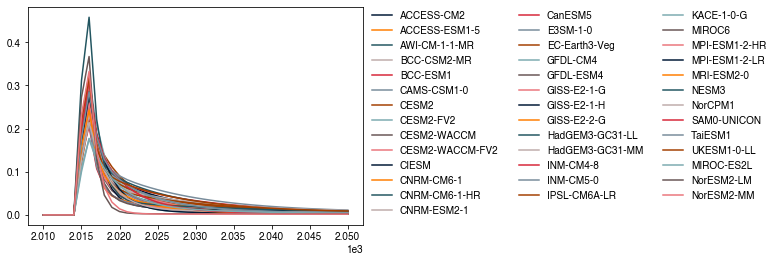

In [6]:
(co2_impulse_test['T']['ssp245_co2_impulse'] - co2_impulse_test['T']['ssp245']).loc[2010:2050].plot(legend=None)
plt.legend(bbox_to_anchor=(1, 0),ncol=3,loc='lower left')

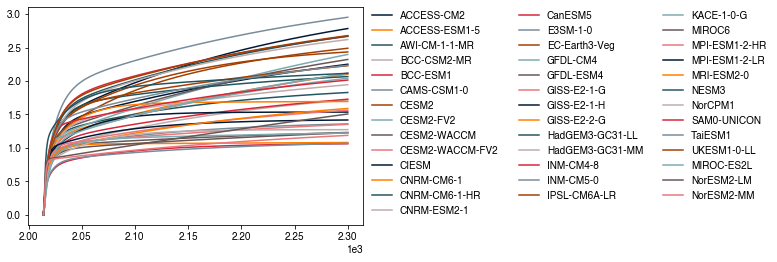

In [7]:
(co2_impulse_test['T']['ssp245_co2_impulse'] - co2_impulse_test['T']['ssp245']).cumsum().loc[2014:2300].plot(legend=None)
plt.legend(bbox_to_anchor=(1, 0),ncol=3,loc='lower left')

In [8]:
## emission pulse

ssp_emms = pd.concat([RCMIP_to_GIR_input_emms('ssp245')]*2,axis=1,keys=['ssp245','ssp245-9.2PgCpulse'])
ssp_emms = ssp_emms.loc[1750:2300].interpolate() - ssp_emms.loc[1750]
ssp_emms.loc[2015,('ssp245-9.2PgCpulse','carbon_dioxide')] += 9.2

ssp245_forc = pd.concat([get_RCMIP_forc('ssp245')]*2,keys=['ssp245','ssp245-9.2PgCpulse'],axis=1).interpolate()
ssp245_forc = ssp245_forc.loc[1750:2300] - ssp245_forc.loc[1861:1880].mean()

In [9]:
co2_emission_impulse_test = run_GIR(emissions_in=ssp_emms,forcing_in=ssp245_forc,gas_parameters=cmip6_gas_params.reindex(cc_params.index,axis=1,level=0),thermal_parameters=fair_param_df.reindex(cc_params.index,axis=1,level=0))

Integrating 2 scenarios, 11 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o

100%|██████████| 550/550 [00:00<00:00, 1415.71 timestep/s]


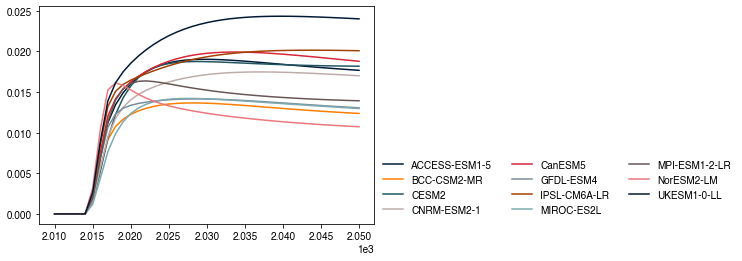

In [10]:
(co2_emission_impulse_test['T']['ssp245-9.2PgCpulse'] - co2_emission_impulse_test['T']['ssp245']).loc[2010:2050].plot(legend=None)
plt.legend(bbox_to_anchor=(1, 0),ncol=3,loc='lower left')

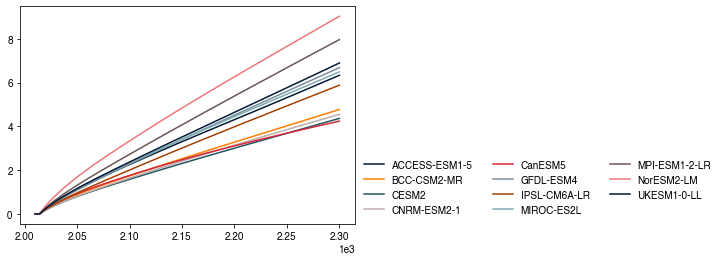

In [11]:
(co2_emission_impulse_test['RF']['ssp245-9.2PgCpulse'] - co2_emission_impulse_test['RF']['ssp245']).xs('Total',axis=1,level=-1).cumsum().loc[2010:2300].plot(legend=None)
plt.legend(bbox_to_anchor=(1, 0),ncol=3,loc='lower left')

[(0.0, 0.48087557925354074),
 (0.0, 3.1003641580739894),
 (0.0, 0.025551170056097063),
 (0.0, 9.479805043564946)]

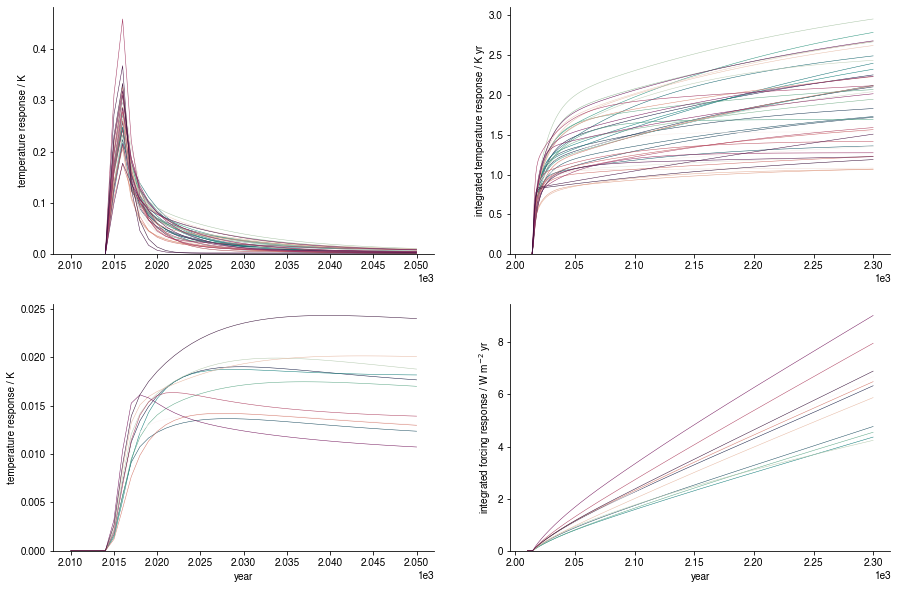

In [26]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

(co2_impulse_test['T']['ssp245_co2_impulse'] - co2_impulse_test['T']['ssp245']).loc[2010:2050].plot(ax=ax[0,0],legend=None,lw=0.5,cmap=cmocean.cm.curl)

(co2_impulse_test['T']['ssp245_co2_impulse'] - co2_impulse_test['T']['ssp245']).cumsum().loc[2010:2300].plot(ax=ax[0,1],legend=None,lw=0.5,cmap=cmocean.cm.curl)

(co2_emission_impulse_test['T']['ssp245-9.2PgCpulse'] - co2_emission_impulse_test['T']['ssp245']).loc[2010:2050].plot(ax=ax[1,0],legend=None,lw=0.5,cmap=cmocean.cm.curl)

(co2_emission_impulse_test['RF']['ssp245-9.2PgCpulse'] - co2_emission_impulse_test['RF']['ssp245']).xs('Total',axis=1,level=-1).cumsum().loc[2010:2300].plot(ax=ax[1,1],legend=None,lw=0.5,cmap=cmocean.cm.curl)

[ax.flatten()[i].set_ylabel(x) for i,x in enumerate(['temperature response / K','integrated temperature response / K yr','temperature response / K','integrated forcing response / W m$^{-2}$ yr'])]
[a.set_xlabel('year') for a in ax[1]]

[a.spines[pos].set_visible(False) for a in ax.flatten() for pos in ['right','top']]
[a.set_ylim(ymin=0) for a in ax.flatten()]